In [0]:
!pip install -q keras
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from IPython.display import SVG, clear_output
from keras.utils import plot_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from sklearn import preprocessing

In [46]:
from google.colab import auth
from googleapiclient.discovery import build
import io , requests, os
import sys
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
K.tensorflow_backend._get_available_gpus()

[]

In [0]:

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

# define path to save model
model_path = 'regression_model_FD003.h5'

In [0]:


# read training data - It is the aircraft engine run-to-failure data.
file_id = '1eUN89qXCWbO0HU-HrMI7KgyRl6L6MCDo'
downloaded = drive.CreateFile({'id':file_id}) # replace the id with id of file you want to access
downloaded.GetContentFile('xyz.csv')  
train_df = pd.read_csv('xyz.csv', sep=" ", header=None)
#print(train_df)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
file_id = '1NJrFcF_n8kZ3kacWVbvZZtWvS7QcHFrM'
downloaded = drive.CreateFile({'id':file_id}) # replace the id with id of file you want to access
downloaded.GetContentFile('xyz.csv')  
test_df = pd.read_csv('xyz.csv', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
file_id = '1oNxk14ASnYYw2sSWyxmgEotxOrYu0nLE'
downloaded = drive.CreateFile({'id':file_id}) # replace the id with id of file you want to access
downloaded.GetContentFile('xyz.csv')  
truth_df = pd.read_csv('xyz.csv', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)


In [0]:
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)


# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)

join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

In [50]:
#@title Default title text
# MinMax normalization
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)


   id  cycle  setting1  setting2  setting3   s1        s2        s3        s4  \
0   1      1  0.401163  0.153846       0.0  0.0  0.257611  0.345077  0.309984   
1   1      2  0.534884  0.307692       0.0  0.0  0.276347  0.402427  0.340718   
2   1      3  0.581395  0.230769       0.0  0.0  0.196721  0.342141  0.231825   
3   1      4  0.656977  0.538462       0.0  0.0  0.318501  0.395968  0.285179   
4   1      5  0.494186  0.538462       0.0  0.0  0.379391  0.484048  0.293292   

    s5     ...           s13       s14       s15  s16       s17  s18  s19  \
0  0.0     ...      0.601190  0.177084  0.530420  0.0  0.272727  0.0  0.0   
1  0.0     ...      0.642857  0.197831  0.603332  0.0  0.272727  0.0  0.0   
2  0.0     ...      0.601190  0.202075  0.480444  0.0  0.272727  0.0  0.0   
3  0.0     ...      0.613095  0.195892  0.518107  0.0  0.363636  0.0  0.0   
4  0.0     ...      0.619048  0.180856  0.623612  0.0  0.272727  0.0  0.0   

        s20       s21  cycle_norm  
0  0.535714  0

In [0]:
# pick a large window size of 50 cycles
sequence_length = 50

def gen_sequence(id_df, seq_length, seq_cols):
   
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 from row 0 to row 50
    # 1 51 from row 1 to row 51
    # 2 52 from row 2 to row 52
    # ...
    # 111 191 from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]
        

In [52]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
print(len(val))

# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to np array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

209
(19720, 50, 25)


In [53]:
# generate labels
def gen_labels(id_df, seq_length, label):
   
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape


(19720, 1)

In [0]:
def r2_keras(y_true, y_pred):
   
    res =  K.sum(K.square( y_true - y_pred ))
    tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - res/(tot + K.epsilon()) )


In [0]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.normalization import BatchNormalization

In [56]:
# Next, we build a deep network. 
# The first layer ==> LSTM layer with 100 units
# Second Layer ==>  LSTM layer with 50 units. 
# Dropout is applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and Relu activation.
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu',
                 input_shape=(sequence_length, nb_features)))
model.add(BatchNormalization())

model.add(MaxPooling1D(pool_size=1))
model.add(LSTM(
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='Adam',metrics=['mae',r2_keras])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 50, 32)            2432      
_________________________________________________________________
batch_normalization_3 (Batch (None, 50, 32)            128       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50, 100)           53200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
__________

In [0]:
# plot
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []        
        self.fig = plt.figure()        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, np.sqrt(self.losses), label="loss")
        plt.plot(self.x, np.sqrt(self.val_losses), label="val_loss")
        plt.ylabel('loss - RMSE')
        plt.xlabel('epoch')
        plt.legend(['train','test'], loc='upper left')
        plt.title('model loss = ' + str(min(np.sqrt(self.val_losses))))
        plt.show();
        
plot_losses = PlotLosses()

In [58]:
# fit the network
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          
                   )

# list all data in history
print(history.history.keys())

#history.save('lstm_rul.h5') 

Train on 18734 samples, validate on 986 samples
Epoch 1/100
 - 69s - loss: 19523.9715 - mean_absolute_error: 107.3384 - r2_keras: -1.4060e+00 - val_loss: 16568.3109 - val_mean_absolute_error: 102.1653 - val_r2_keras: -3.6274e+00
Epoch 2/100
 - 66s - loss: 17990.0549 - mean_absolute_error: 100.6268 - r2_keras: -1.2151e+00 - val_loss: 15562.1680 - val_mean_absolute_error: 97.6815 - val_r2_keras: -3.3099e+00
Epoch 3/100
 - 66s - loss: 17039.7213 - mean_absolute_error: 96.3192 - r2_keras: -1.0973e+00 - val_loss: 14661.7531 - val_mean_absolute_error: 93.5779 - val_r2_keras: -3.0314e+00
Epoch 4/100
 - 68s - loss: 16153.2607 - mean_absolute_error: 92.0401 - r2_keras: -9.8883e-01 - val_loss: 13812.2629 - val_mean_absolute_error: 89.1647 - val_r2_keras: -2.7588e+00
Epoch 5/100
 - 67s - loss: 15340.9644 - mean_absolute_error: 88.2043 - r2_keras: -8.8787e-01 - val_loss: 13033.1501 - val_mean_absolute_error: 85.5757 - val_r2_keras: -2.5217e+00
Epoch 6/100
 - 66s - loss: 14581.1082 - mean_absolute_

Epoch 24/100
 - 66s - loss: 6505.4270 - mean_absolute_error: 44.0700 - r2_keras: 0.2062 - val_loss: 4587.8391 - val_mean_absolute_error: 44.2451 - val_r2_keras: -2.4549e-01
Epoch 25/100
 - 67s - loss: 6259.1045 - mean_absolute_error: 42.7708 - r2_keras: 0.2361 - val_loss: 4386.4902 - val_mean_absolute_error: 44.4942 - val_r2_keras: -2.5017e-01
Epoch 26/100
 - 66s - loss: 6021.4828 - mean_absolute_error: 41.4047 - r2_keras: 0.2659 - val_loss: 4136.2001 - val_mean_absolute_error: 42.5530 - val_r2_keras: -1.6853e-01
Epoch 27/100
 - 66s - loss: 5770.3101 - mean_absolute_error: 40.2623 - r2_keras: 0.2977 - val_loss: 3949.4298 - val_mean_absolute_error: 40.9960 - val_r2_keras: -1.5716e-01
Epoch 28/100
 - 67s - loss: 5550.5256 - mean_absolute_error: 39.0909 - r2_keras: 0.3228 - val_loss: 3720.9467 - val_mean_absolute_error: 39.0896 - val_r2_keras: 0.0152
Epoch 29/100
 - 66s - loss: 5379.9927 - mean_absolute_error: 38.4326 - r2_keras: 0.3441 - val_loss: 3517.5392 - val_mean_absolute_error: 38.

Epoch 48/100
 - 33s - loss: 2641.4623 - mean_absolute_error: 23.5183 - r2_keras: 0.6798 - val_loss: 1628.3466 - val_mean_absolute_error: 26.9932 - val_r2_keras: 0.4108
Epoch 49/100
 - 51s - loss: 2530.3435 - mean_absolute_error: 22.9994 - r2_keras: 0.6936 - val_loss: 1213.7422 - val_mean_absolute_error: 22.9163 - val_r2_keras: 0.6212
Epoch 50/100
 - 34s - loss: 2462.0936 - mean_absolute_error: 22.9269 - r2_keras: 0.7009 - val_loss: 1039.0626 - val_mean_absolute_error: 20.7296 - val_r2_keras: 0.6322
Epoch 51/100
 - 34s - loss: 2349.3851 - mean_absolute_error: 22.1941 - r2_keras: 0.7153 - val_loss: 1698.6147 - val_mean_absolute_error: 26.8202 - val_r2_keras: 0.4881
Epoch 52/100
 - 34s - loss: 2270.5251 - mean_absolute_error: 21.6516 - r2_keras: 0.7258 - val_loss: 1620.1798 - val_mean_absolute_error: 27.1222 - val_r2_keras: 0.3343
Epoch 53/100
 - 33s - loss: 2200.1048 - mean_absolute_error: 21.1703 - r2_keras: 0.7335 - val_loss: 1037.7939 - val_mean_absolute_error: 20.9572 - val_r2_keras:

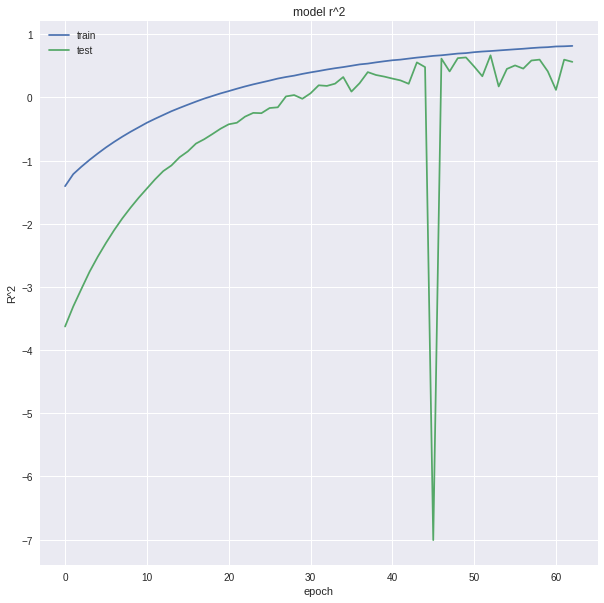

In [59]:
# summarize for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_r2.png")

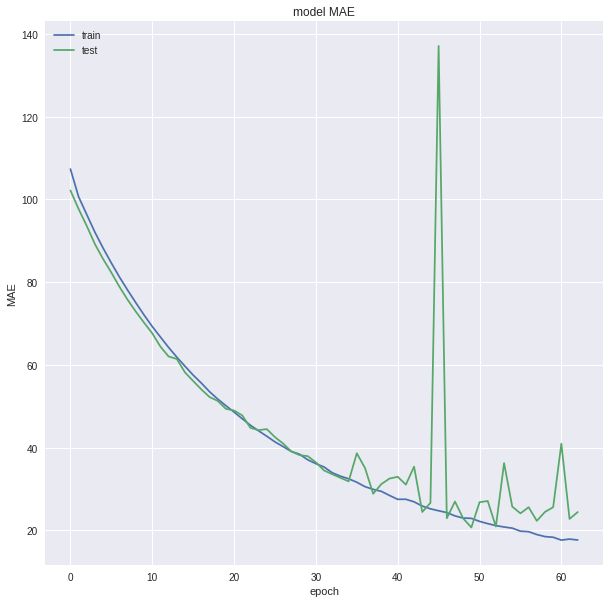

In [60]:

# summarize for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")

[16568.310884611117, 15562.167994005928, 14661.753144858092, 13812.262861333078, 13033.15014487493, 12305.061357416922, 11619.48400971759, 10979.508261040306, 10379.536524650775, 9815.90341626026, 9283.676578235432, 8774.120510511417, 8299.210618643925, 7882.474062627518, 7442.744914861528, 7049.292473597652, 6664.855700773352, 6315.035780003298, 5992.315120550004, 5666.322266924937, 5398.632666040386, 5135.898846608872, 4818.675756179779, 4587.839139493435, 4386.490246012535, 4136.200075842063, 3949.4297598012804, 3720.9466608910243, 3517.5392099500427, 3362.6363790330247, 3168.748186030204, 3015.3739693198677, 2807.090111165695, 2641.9971663221627, 2521.922687878715, 2945.9250550183033, 2674.0417991158447, 2086.38848456021, 2286.6327085669095, 2306.106371773184, 2332.2750523936675, 1978.7779484065986, 2777.6155824796665, 1511.1737549261438, 1593.1367282828744, 28306.23481920718, 1386.7710007363835, 1628.3466285566287, 1213.7422437687192, 1039.0626422502933, 1698.6147286374478, 1620.1

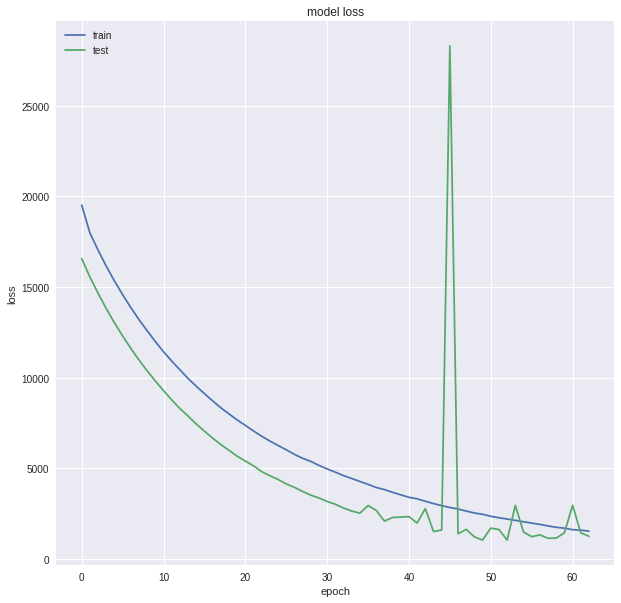

In [61]:
# summarize for Loss
print(history.history['val_loss'])
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_regression_loss.png")


In [62]:

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

19720/19720 [==============================] - 11s 572us/step

MAE: 26.5127509274

R^2: 0.46418921858


In [63]:
y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array
submit = np.concatenate((y_pred, y_true), axis=1)
print(submit)

test_set = pd.DataFrame(y_pred)
test_set.to_csv('submit_train.csv', index = None)


19720/19720 [==============================] - 12s 599us/step
[[215.23103   208.       ]
 [216.05054   207.       ]
 [216.49805   206.       ]
 ...
 [  5.1452637   2.       ]
 [  4.0867925   1.       ]
 [  4.200948    0.       ]]


In [64]:
# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)


(97, 1)


In [0]:
def score_cal(y_hat, Y_test):
    d   = y_hat - Y_test
    tmp = np.zeros(d.shape[0])
    for i in range(d.shape[0]):
        if d[i,0] >= 0:
           tmp[i] = np.exp( d[i,0]/10) - 1
        else:
           tmp[i] = np.exp(-d[i,0]/13) - 1
    return tmp 


MAE: 16.7811511325

R^2: -760989.865747
[[ 44.         48.42933  ]
 [ 51.         60.830864 ]
 [ 27.         29.502644 ]
 [120.        123.87768  ]
 [101.        147.87668  ]
 [ 99.        100.3964   ]
 [ 71.         72.35131  ]
 [ 55.         53.66172  ]
 [ 55.         69.96374  ]
 [ 66.         69.10977  ]
 [ 77.         72.313675 ]
 [115.         72.50147  ]
 [115.        101.92661  ]
 [ 31.         34.68715  ]
 [108.        124.47952  ]
 [ 56.         82.58052  ]
 [136.        141.68219  ]
 [132.        155.095    ]
 [ 85.        124.8749   ]
 [ 56.         54.31609  ]
 [ 18.         16.07587  ]
 [119.        134.69856  ]
 [ 78.         75.331665 ]
 [  9.          4.893554 ]
 [ 58.         51.610565 ]
 [ 11.         12.168434 ]
 [ 88.        125.41827  ]
 [144.        179.12422  ]
 [124.         93.46308  ]
 [ 89.         86.54045  ]
 [ 79.         87.38651  ]
 [ 55.         45.279324 ]
 [ 71.        104.99852  ]
 [ 65.        106.8649   ]
 [ 87.         90.14299  ]
 [137.        

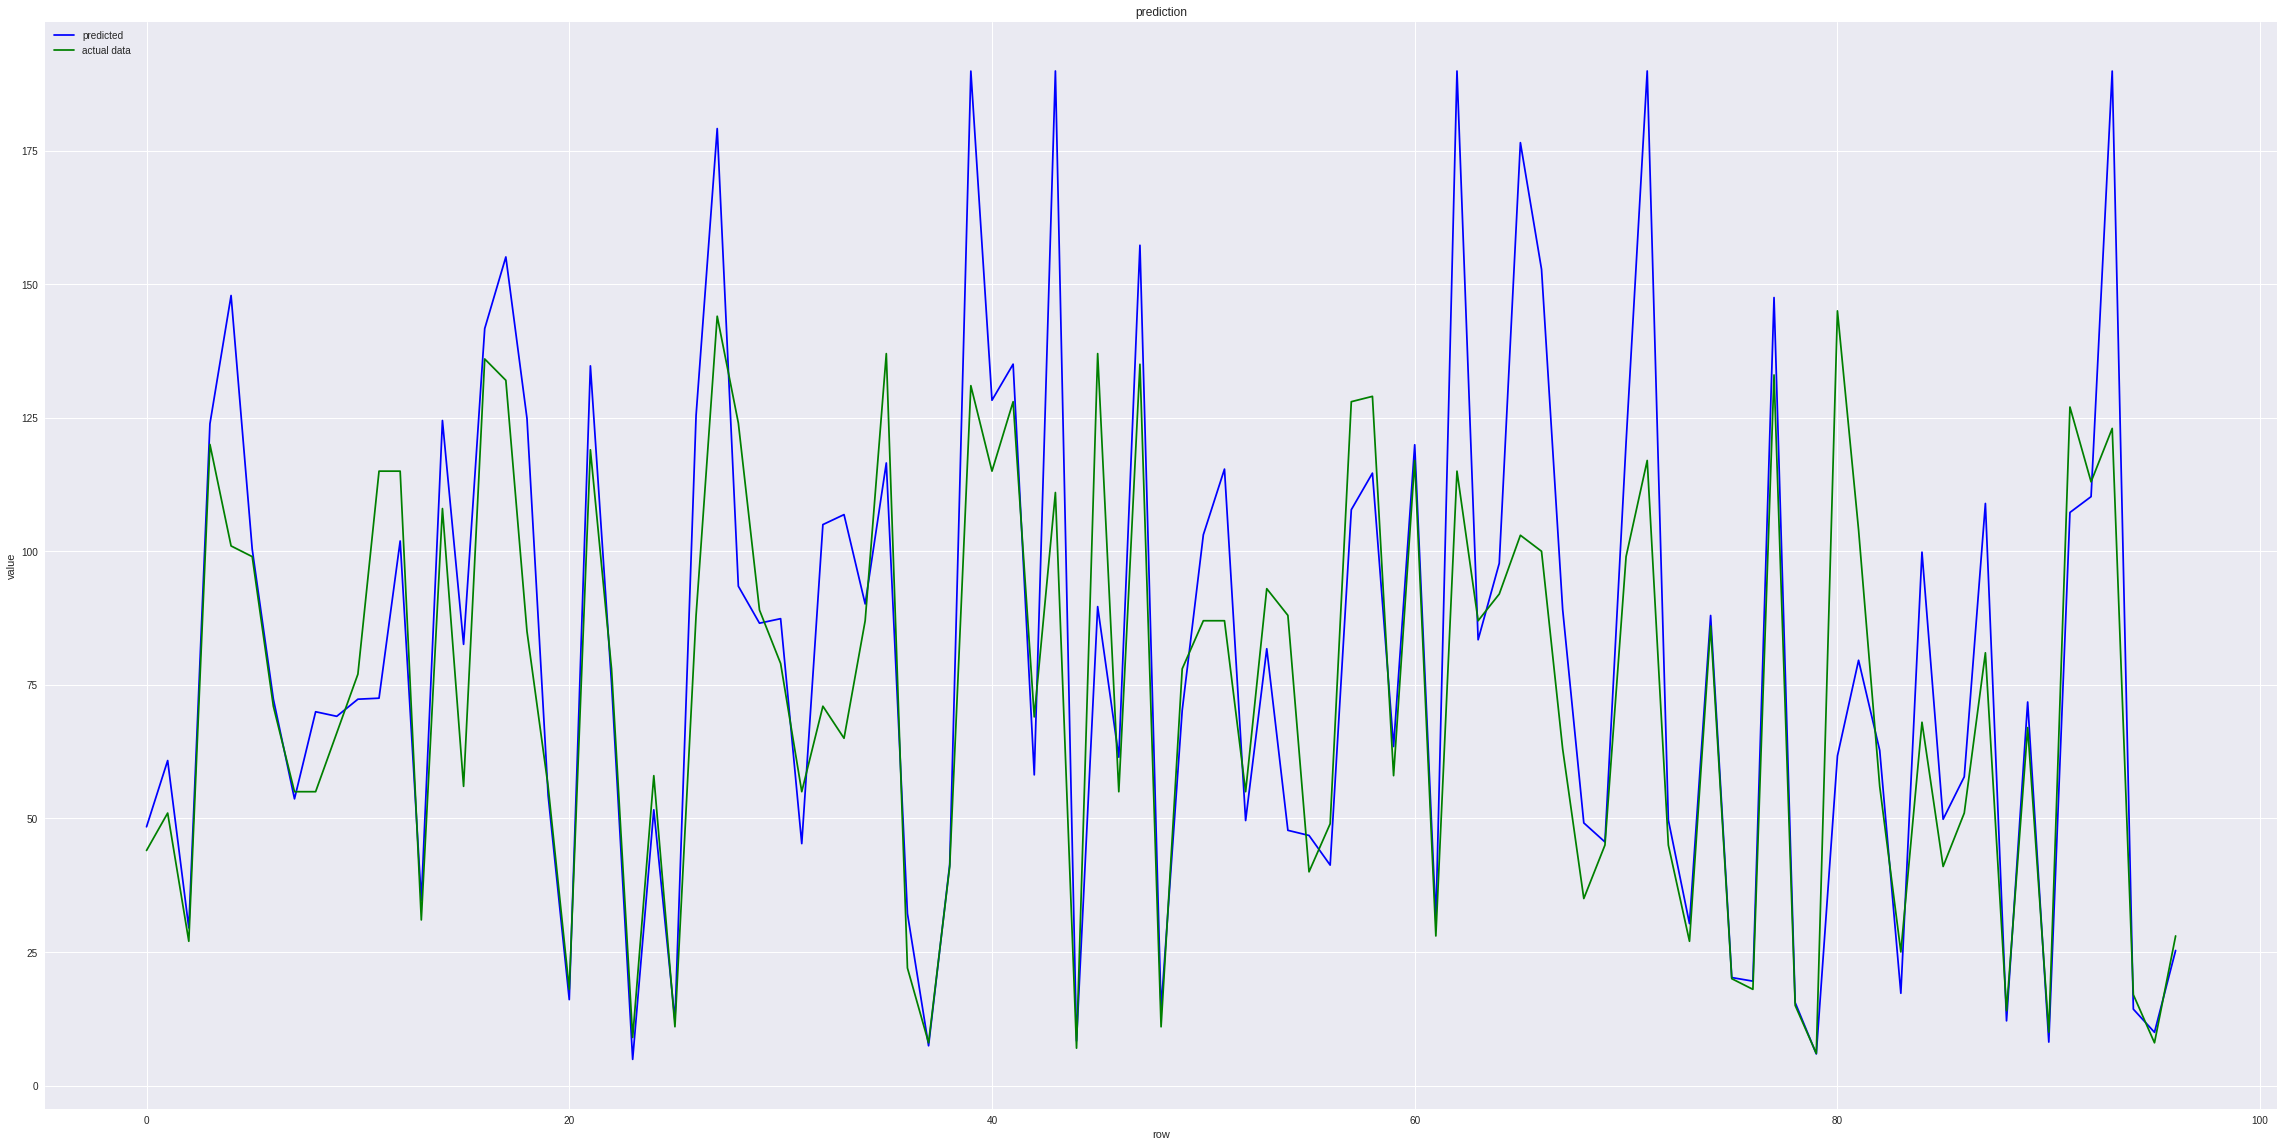

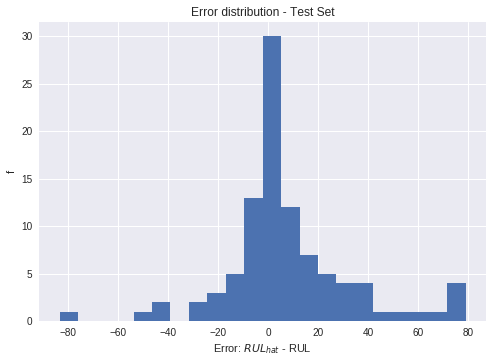

Score = 10036.702191473032


In [66]:
# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    submit = np.concatenate((y_true_test, y_pred_test), axis=1)
    print(submit)
    test_set.to_csv('submit_test.csv', index = None)

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(40, 20))
    plt.plot(y_pred_test, color="blue")
    plt.plot(y_true_test, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("model_regression_verify.png")
    
    d = y_pred_test - y_true_test
    plt.hist(d, bins='auto')  
    plt.title('Error distribution - Test Set')
    plt.ylabel('f')
    plt.xlabel("Error: $RUL_{hat}$ - RUL")
    plt.show()
    
    score_i_tr = score_cal(y_pred_test, y_true_test)
    print("Score = " + str(sum(score_i_tr)))